In [7]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

import matplotlib.pyplot as plt
import torch

from nerf2d import NeRF2D_LightningModule
from nerf2d_dataset import NeRF2D_Datamodule

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
ckpt_path = '../checkpoints/last-v3.ckpt'
nerf: NeRF2D_LightningModule = NeRF2D_LightningModule.load_from_checkpoint(ckpt_path).to('cpu')

In [3]:
# read test set
dataset_folder = Path('../data/cube')
dm = NeRF2D_Datamodule(dataset_folder)

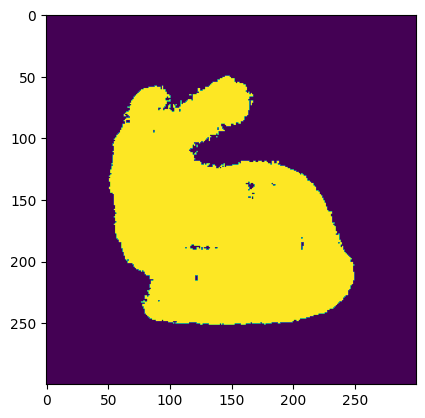

In [4]:
densities = nerf.render_density_field(res=300)
plt.imshow(densities > 0.1)

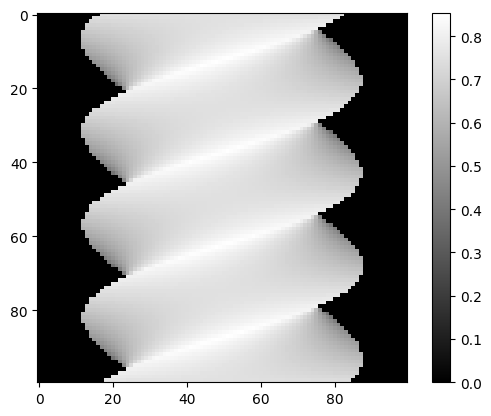

In [22]:
renders_depth = []
gt_depth = []

for batch in dm.val_dataloader():
    origins, directions, colors_gt, depth_gt = batch
    # forward pass
    # outs = nerf.forward(origins, directions)
    gt_depth.append(depth_gt)

depth = torch.stack(gt_depth)
depth = nerf.normalize_depth(depth)

plt.imshow(depth, cmap='gray')
plt.colorbar()

In [30]:
batch = next(iter(dm.val_dataloader()))
origins, directions, colors_gt, depth_gt = batch

with torch.no_grad():
    nerf.forward(origins, directions)

